In [ ]:
from bondable.bond.config import Config
from bondable.bond.functions import Functions
from bondable.bond.threads import Threads
from bondable.bond.agent import Agent
from bondable.bond.broker import Broker, BrokerConnectionEmpty
import os
import queue
import threading
import io
import json
from IPython.display import Image, display
import base64
from pydantic import BaseModel
from typing import List, Optional
from dotenv import load_dotenv
from typing_extensions import override
import logging
load_dotenv(override=True)

print("OpenAI Project: ", os.getenv("OPENAI_PROJECT", "None Found"))
print("Azure OpenAI Endpoint: ", os.getenv("AZURE_OPENAI_ENDPOINT", "None Found"))

logging.basicConfig(
  level=logging.INFO,  
  format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",  
)
logging.getLogger("httpx").setLevel(logging.WARNING)

LOGGER = logging.getLogger(__name__)

user_id = "test@user.com"

session = {}
session['user_id'] = user_id
config = Config.config()
openai_client = config.get_openai_client()
openai_deployment = config.get_openai_deployment()
builtin_functions = Functions.functions()
broker = Broker.broker()
threads = Threads.threads(user_id=user_id)

# def ask_agent (question, thread, agent):
#   messages = agent.get_response(question, thread.id)
#   for msg in messages:
#     print(f"{msg['role']}: {msg['content']}")

# class MyThreadMessageHandler(ThreadMessageHandler):

#   def set_parser(self, parser:ThreadMessageParser):
#     self.parser = parser

#   def onMessage(self, thread_id, message_id, type, role, is_error=False, is_done=False, clob=None):
#       if role == 'system':
#         LOGGER.info(f"Received system message, ignoring {message_id}")
#         self.parser.stop()

#       if type == "text":
#           if clob is not None:
#             print(f"[{message_id}/{role}/{type}] => {clob.get_content()}")
#       elif type == "image_file":
#           if clob is not None:
#             print(f"[{id}/{role}/{type}] => ")
#             content = clob.get_content()
#             if content.startswith('data:image/png;base64,'):
#               base64_image = content[len('data:image/png;base64,'):]
#               image_data = base64.b64decode(base64_image)
#               display(Image(data=image_data))  
#       else:
#           LOGGER.error(f"Unknown message type {type}")

# class MyHandler(AgentResponseHandler):
#     @override
#     def on_content(self, content, id, type, role):
#         if type == "text":
#           print(f"[{id}/{role}/{type}] => {content}")
#         elif type == "image_file":
#           print(f"[{id}/{role}/{type}] => ")
#           if content.startswith('data:image/png;base64,'):
#               base64_image = content[len('data:image/png;base64,'):]
#               image_data = base64.b64decode(base64_image)
#               display(Image(data=image_data))
#           else:
#               print("Invalid image data")
#     @override
#     def on_done(self, success=True, message=None):
#         pass

def display_message (message):

  if message.role == 'system':
    LOGGER.debug(f"Received system message, ignoring {message.message_id}")
    return

  if message.type == "text":
    print(f"[{message.message_id}/{message.role}] => {message.clob.get_content()}")
  elif message.type == "image_file":
    print(f"[{message.message_id}/{message.role}] => ")
    content = message.clob.get_content()
    if content.startswith('data:image/png;base64,'):
      base64_image = content[len('data:image/png;base64,'):]
      image_data = base64.b64decode(base64_image)
      display(Image(data=image_data))  
  else:
      LOGGER.error(f"Unknown message type {type}")

def ask_agent (prompt, thread_id, agent):
  conn = broker.connect(thread_id=thread_id, subscriber_id=user_id)
  message = agent.create_user_message(prompt, thread_id)
  thread = threading.Thread(target=agent.broadcast_response, args=(None, thread_id), daemon=True)
  thread.start()
  while True:
      try:
          bond_msg = conn.wait_for_message(timeout=5)
          if bond_msg is None:
              break
          display_message(bond_msg)
          if bond_msg.is_done:
              break
      except BrokerConnectionEmpty:
          continue
      except Exception as e:
          LOGGER.error(f"Error: {e}")
          break
  thread.join()
  conn.close()
      

agent_names = [
  "Simple Agent",
  # "Spreadsheet Agent",
  # "Tool Agent",
  # "Googlesheet Agent",
  # "Message Action Agent",
]

all_assistants = openai_client.beta.assistants.list(
    order="desc",
    limit="20",
)
existing_assistants = {assistant.name: assistant.id for assistant in all_assistants.data if assistant.name in agent_names}
print(f"Existing assistants: {list(existing_assistants.keys())}")

# test a question
if len(existing_assistants) == 0:
  print("No assistants found")
else:
  agent = Agent.get_agent_by_name(name=list(existing_assistants.keys())[0])
  thread_id = threads.create_thread()
  ask_agent("Tell me a joke", thread_id, agent)
  threads.delete_thread(thread_id)


OpenAI Project:  proj_y8S5IhjXjiQfnOesz83psTlC
Azure OpenAI Endpoint:  None Found
Existing assistants: ['Simple Agent']
[msg_RaMGBsaAlMmM4X5rtWvjQ5KQ/user] => Tell me a joke
[msg_iZN09w3m72aN0Yf9hy5Ipx2X_0/assistant] => Sure! Here's a classic one for you:

Why don't scientists trust atoms?

Because they make up everything!


In [ ]:

# inititialize all of the agents that we will be using
for name in agent_names:
  if name in list(existing_assistants.keys()):
    response = openai_client.beta.assistants.delete(existing_assistants[name])
    print('Deleted assistant:', name)
  new_assistant = openai_client.beta.assistants.create(
    instructions="",
    name=name,
    tools=[],
    model=openai_deployment
  )
  print('Created simple assistant:', name)

all_assistants = openai_client.beta.assistants.list(
    order="desc",
    limit="20",
)
existing_assistants = {assistant.name: assistant.id for assistant in all_assistants.data if assistant.name in agent_names}
print(f"Existing assistants: {existing_assistants}")


In [12]:
# create a simple agent that barely changes the default behavior
class SimpleAnswer(BaseModel):
    answer: str
    graph: Optional[str]

simple_assistant = openai_client.beta.assistants.update(
    assistant_id=existing_assistants["Simple Agent"],
    name="Simple Agent",
    description="An agent that will load synthetic data about people and answer questions",
    instructions="""When you begin you should create a synthetic data set that has the weight 
    and height of 100 people. You should answer questions about the data set and include an graph. 
    When asked a question you should start by explaining how you are going to answer the question, 
    then provide a graph to illustrate your answer, and finally provide a short answer to the question. 
    You must always provide some kind of illustration, such as a grpah, between your explanantion and 
    your answer.
    """,
    tools=[{"type": "code_interpreter"}],
    model=openai_deployment,
    metadata={'visible': 'True', 'initial_prompt': 'Show a bar graph representation of the data'},
    # response_format={
    #     "type":"json_schema",
    #     "json_schema":{
    #         "name": "output_schema",
    #         "schema": SimpleAnswer.model_json_schema(),
    #     }
    # },
)
simple_agent = Agent.get_agent_by_name(name=simple_assistant.name)

[msg_tesdRT65bjx9b6yGG05NEdap/user] => How many people are there
[msg_AURTeiZft91yoNJZPhOr0Vkk_0/assistant] => To answer your question, I'll first create a synthetic dataset containing the weight and height of 100 individuals. This dataset will then provide the figures for the number of people, which is essentially the total count of entries in the dataset.

Let's create that dataset first.
[msg_UPI3TmVC6EgnO2siR6TBheTi_0/assistant] => I have created a synthetic dataset consisting of the height and weight of 100 individuals. 

Now, let's visualize the number of people in this dataset using a simple bar chart that shows the count of instances. This will clearly demonstrate that there are 100 entries in the dataset. 

Let's plot that graph.
[msg_Bfh8HlHxTuFNRSrRqdLg8I6L_0/assistant] => 


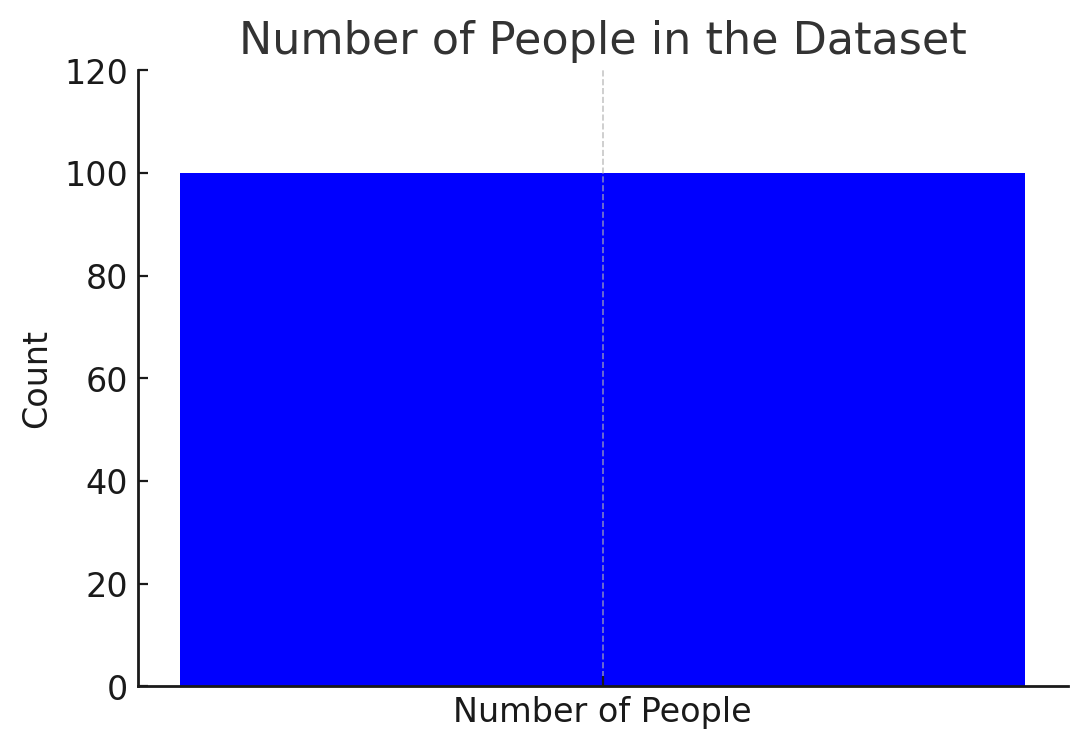

[msg_Bfh8HlHxTuFNRSrRqdLg8I6L_1/assistant] => The graph above visually represents the total number of people in the dataset, which is 100. 

To summarize, there are 100 entries (or people) in the synthetic dataset created.
[msg_vGrKpeERRBd61ozm3ueI6tLk/user] => Show me a scatterplot of height vs weight
[msg_ZnjYCU1NQd60cZQfjrkyWODz_0/assistant] => To create a scatterplot of height versus weight, I will use the synthetic dataset we created earlier. The scatterplot will allow us to visualize the relationship between the two variables: height (in cm) and weight (in kg).

I'll generate the scatterplot now.
[msg_77R2ND8SKULFwUlqyEAW8jNg_0/assistant] => 


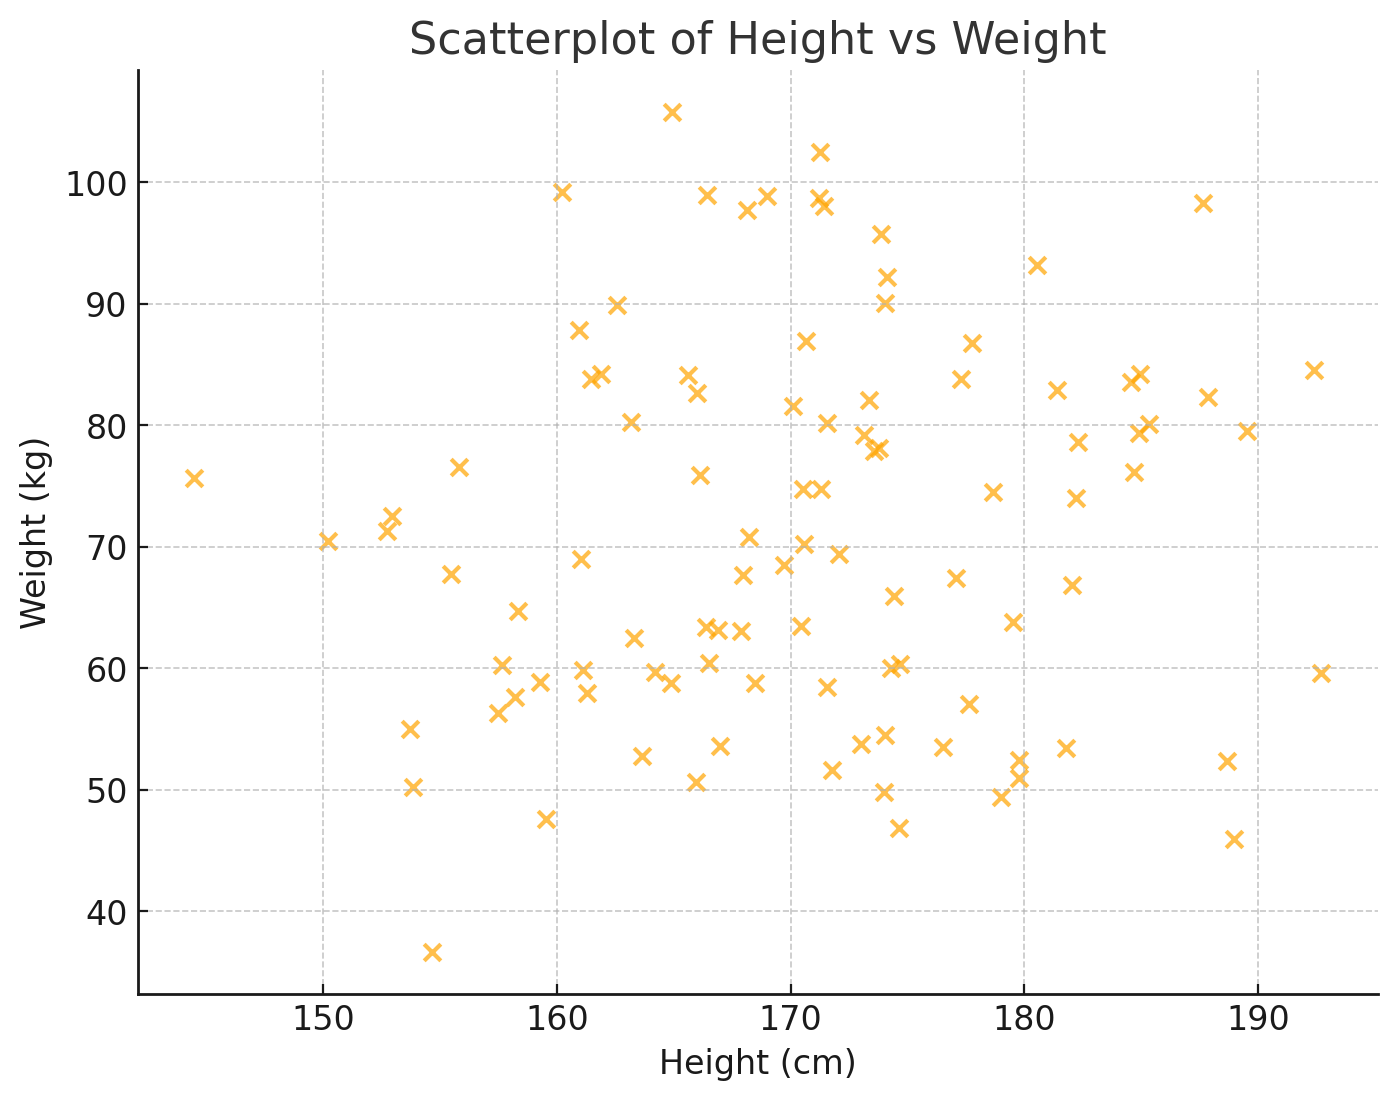

[msg_77R2ND8SKULFwUlqyEAW8jNg_1/assistant] => The scatterplot above illustrates the relationship between height and weight among the 100 individuals in the dataset.

In this scatterplot:
- The x-axis represents the height (in cm).
- The y-axis represents the weight (in kg).

From the plot, we can observe that there appears to be a positive correlation between height and weight. Generally, as height increases, weight tends to increase as well, although there are some variations.

In summary, the scatterplot effectively visualizes the relationship between height and weight, showing a tendency for higher weights with taller heights.
[msg_ofgGZ1FdkFRSO9MLmYPbIrIf/user] => Can you create a simple graph for me that contains synthetic data comparing height and weight in bears
[msg_nSQZJSAZVvitNLLJQYoZiwgT_0/assistant] => To create a simple graph comparing height and weight in bears, I will generate a synthetic dataset specifically for bear characteristics. The dataset will include the heights

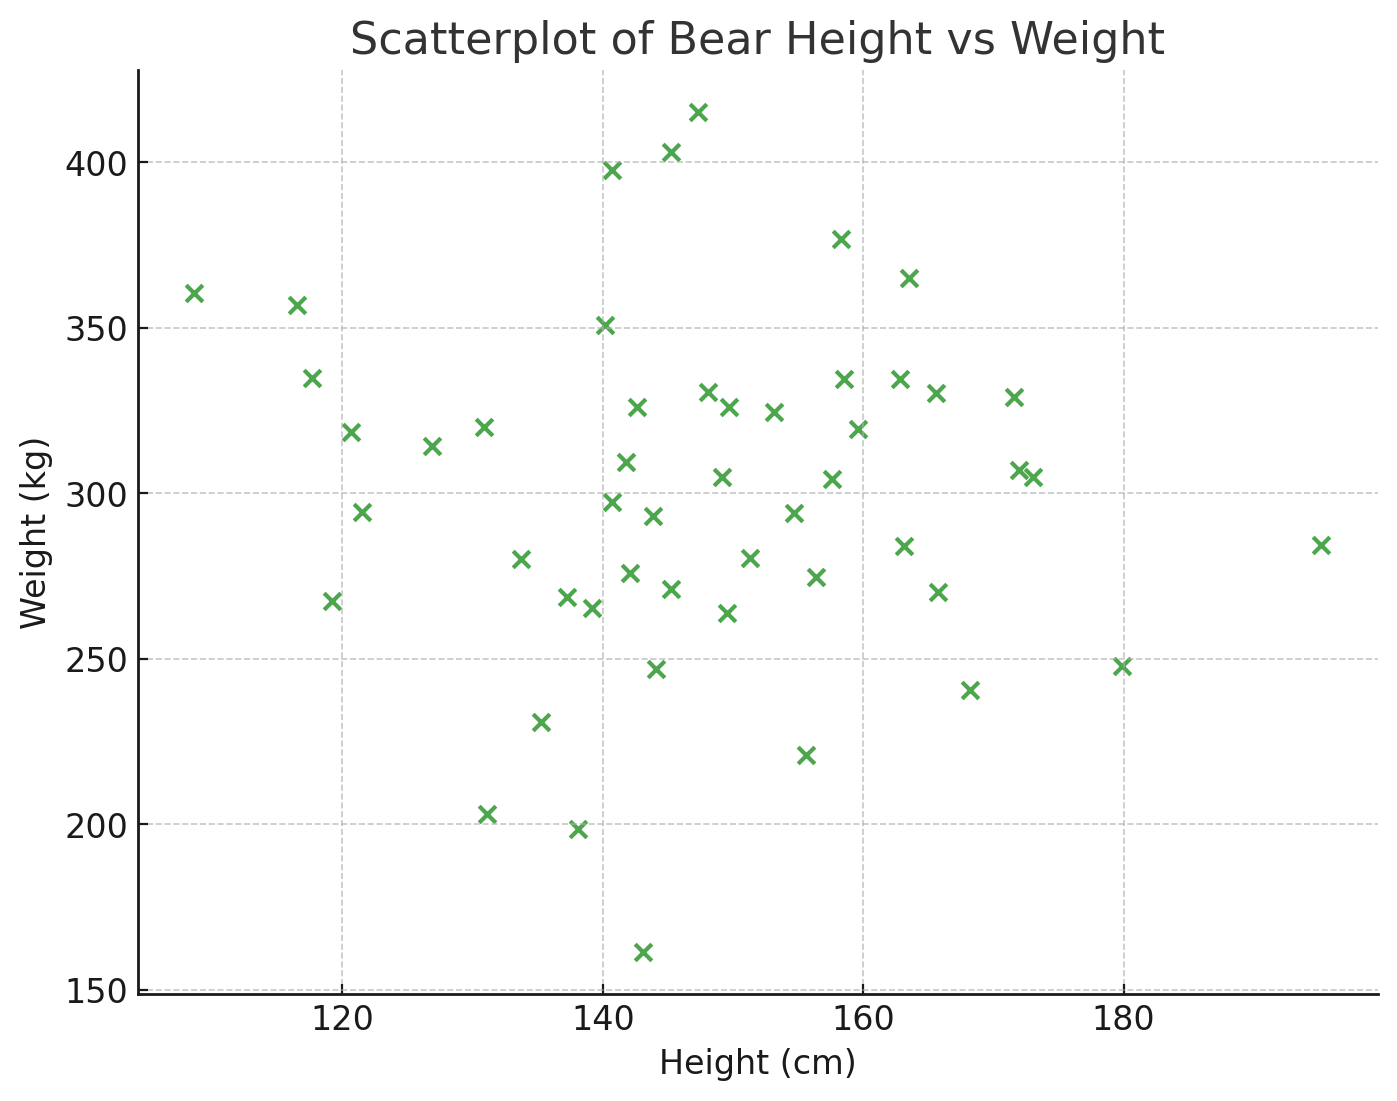

[msg_ugzrS3trNSpeTpcwnWgGN7ha_1/assistant] => The scatterplot above displays the relationship between height and weight for a synthetic dataset of bears.

In this plot:
- The x-axis represents the height of the bears (in cm).
- The y-axis represents the weight of the bears (in kg).

From the scatterplot, it seems there is a general tendency for heavier bears to also be taller, similar to the relationship observed in humans. However, individual variations are present.

In summary, this scatterplot effectively visualizes the synthetic data comparing the heights and weights of bears.


In [11]:
thread_id = threads.create_thread()
ask_agent("How many people are there", thread_id, simple_agent)
ask_agent("Show me a scatterplot of height vs weight", thread_id, simple_agent)
ask_agent("Can you create a simple graph for me that contains synthetic data comparing height and weight in bears", thread_id, simple_agent)
threads.delete_thread(thread_id)


In [ ]:
# ask another questions
ask_agent_stream("Show me a scatterplot of height vs weight", thread, simple_agent)
response = openai_client.beta.threads.delete(thread.id)

In [ ]:
thread = openai_client.beta.threads.create()
ask_agent_stream("Can you create a simple graph for me that contains synthetic data comparing height and weight in bears", thread, simple_agent)
response = openai_client.beta.threads.delete(thread.id)

In [ ]:
# create an agent that uses an uploaded spreadsheet to answer questions

# first upload the file to the assistant
data_file = os.getenv("CUSTOMER_DATA_FILE")
file = openai_client.files.create(
  file=open(data_file, "rb"),
  purpose='assistants'
)

# create the agent with the uploaded file
spreadsheet_assistant = openai_client.beta.assistants.update(
    assistant_id=existing_assistants["Spreadsheet Agent"],
    name="Spreadsheet Agent",
    instructions="""
    Use the spreadsheet to answer questions about customers. The attached spreadsheet
    constains information about the customers in CSV format. The first row contains the
    names of the columns. 
    """,
    tools=[{"type": "code_interpreter"}],
    tool_resources={
      "code_interpreter": {
        "file_ids": [file.id]
      }
    },
    model=openai_deployment,
)
spreadsheet_agent = Agent(assistant_id=spreadsheet_assistant.id, name=spreadsheet_assistant.name, config=config)

In [ ]:
thread = openai_client.beta.threads.create()
ask_agent_stream("How many customers are there", thread, spreadsheet_agent)
response = openai_client.beta.threads.delete(thread.id)


In [ ]:
# create an agent that uses a tool written as a python method to answer questions
# the python method 'use_numbers' lives in fumctions.py

simpletool_assistant = openai_client.beta.assistants.update(
    assistant_id=existing_assistants["Tool Agent"],
    name="Tool Agent",
    instructions="""
    You are a helpful assistant that answers questions about numbers. When the user
    gives you two numbers, you will use them to call the function 'use_numbers'. The use
    the result of that function to answer the question.
    """,
    tools=[{"type": "code_interpreter"},
       {
        "type": "function",
        "function": {
          "name": "use_numbers",
          "description": "use two numbers to generate a result",
          "parameters": {
            "type": "object",
            "properties": {
              "a": {
                "type": "integer",
                "description": "first number"
              },
              "b": {
                "type": "integer",
                "description": "second number"
              },
            },
            "required": ["a", "b"]
          }
        }
      }],
    model=openai_deployment,
)
simpletool_agent = Agent(assistant_id=simpletool_assistant.id, name=simpletool_assistant.name, config=config)

In [ ]:

thread = openai_client.beta.threads.create()
ask_agent_stream("The numbers are 4 and 3", thread, simpletool_agent)
response = openai_client.beta.threads.delete(thread.id)

In [ ]:
# create an agent that uses a tool written as a python method to answer questions
# the python method 'execute_sql_googlesheets' lives in fumctions.py
# this function will execute a SQL query on a google sheet

googlesheet_assistant = openai_client.beta.assistants.update(
    assistant_id=existing_assistants["Googlesheet Agent"],
    name="Googlesheet Agent",
    instructions="""
    You are an expert answering questions about customers. When asked a question, you should
    translate the question into a SQL query and execute it using the function execute_sql_googlesheets.
    The table name is 'df' and the columns are:
    - Customer_ID
    - First_Name
    - Last_Name
    - Email
    - Phone_Number
    - Region
    - Salesperson
    - Address
    - ZIP_Code
    - Last_Purchase_Amount

    An example question might be "How many customers are in each regio" which you would translate into:
    SELECT Region, COUNT(*) FROM df GROUP BY Region
    """,
    tools=[{"type": "code_interpreter"},
       {
        "type": "function",
        "function": {
          "name": "execute_sql_googlesheets",
          "description": "execute a sql query on a google sheet",
          "parameters": {
            "type": "object",
            "properties": {
              "sql_query": {
                "type": "string",
                "description": "the query to execute"
              }
            },
            "required": ["sql_query"]
          }
        }
      }],
    model=openai_deployment,
)

googlesheet_agent = Agent(assistant_id=googlesheet_assistant.id, functions=builtin_functions)


In [ ]:

thread = openai_client.beta.threads.create()
ask_agent_stream("how many customers are there", thread, googlesheet_agent)
response = openai_client.beta.threads.delete(thread.id)

In [ ]:
# create an agent that uses two tools written as python methods to answer requests
# both python methods lives in fumctions.py
# the function 'execute_sql_googlesheets' will execute a SQL query on a google sheet
# the function 'send_email' will send an email

message_assistant = openai_client.beta.assistants.update(
    assistant_id=existing_assistants["Message Action Agent"],
    name="Message Action Agent",
    instructions="""
    You are an expert answering questions about customers. When asked a question, you should
    translate the question into a SQL query and execute it using the function execute_sql_googlesheets.
    The table name is 'df' and the columns are:
    - Customer_ID
    - First_Name
    - Last_Name
    - Email
    - Phone_Number
    - Region
    - Salesperson
    - Address
    - ZIP_Code
    - Last_Purchase_Amount

    An example question might be "How many customers are in each regio" which you would translate into:
    SELECT Region, COUNT(*) FROM df GROUP BY Region

    You can also send a message with results for any user questions using the function 'send_email'.
    THis function takes a message body, a subject and a to email address as parameters. 
    """,
    tools=[{"type": "code_interpreter"},
       {
        "type": "function",
        "function": {
          "name": "execute_sql_googlesheets",
          "description": "execute a sql query on a google sheet",
          "parameters": {
            "type": "object",
            "properties": {
              "sql_query": {
                "type": "string",
                "description": "the query to execute"
              }
            },
            "required": ["sql_query"]
          }
        }
      },
      {
        "type": "function",
        "function": {
          "name": "send_email",
          "description": "send an email",
          "parameters": {
            "type": "object",
            "properties": {
              "to": {
                "type": "string",
                "description": "the to address"
              },
              "subject": {
                "type": "string",
                "description": "the subject of the email"
              },
              "body": {
                "type": "string",
                "description": "the body of the email"
              }
            },
            "required": ["to", "subject", "body"]
          }
        }
      },
      ],
    model=openai_deployment,
)

In [ ]:
agent = Agent(assistant_id=message_assistant.id, functions=builtin_functions)
thread = openai_client.beta.threads.create()
ask_agent("how many customers are there", thread, agent)
response = openai_client.beta.threads.delete(thread.id)